# MAIN QUEST 04. 데이터 분석 후 회귀 모델 만들기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub, os
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import ttest_ind
from patsy import dmatrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
path = kagglehub.dataset_download('tunguz/online-retail')
df = pd.read_csv(path + '/' + os.listdir(path)[0], encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 1. 모집단과 표본 집단의 TotalPrice를 비교해 주세요.

* 데이터셋에서 무작위로 1000개의 표본을 추출하세요.
* 추출된 표본과 전체 데이터셋의 'TotalPrice'에 대해 평균과 표준편차를 비교해주세요.  
* 중심극한정리를 사용해 모집단과 표본의 차이를 설명해주세요.

In [4]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
sample = df['TotalPrice'].sample(n=1000, random_state=42)

pop_mean = df['TotalPrice'].mean()
pop_std = df['TotalPrice'].std()

sample_mean = sample.mean()
sample_std = sample.std()

print('--------- 모집단 ---------')
print(f'모집단 평균\t: {pop_mean:.4f}')
print(f'모집단 표준편차\t: {pop_std:.4f}')
print('\n-------- 표본집단 --------')
print(f'표본집단 평균\t: {sample_mean:.4f}')
print(f'표본집단 표준편차: {sample_std:.4f}')

--------- 모집단 ---------
모집단 평균	: 17.9878
모집단 표준편차	: 378.8108

-------- 표본집단 --------
표본집단 평균	: 16.8321
표본집단 표준편차: 64.4673


In [5]:
diff = sample_mean - pop_mean

print(f'\n표본 평균 - 모집단 평균 = {diff:,.4f}')


표본 평균 - 모집단 평균 = -1.1557


- 모집단 평균 vs 표본집단 평균
  - 모집단 평균(17.99)과 표본집단 평균(378.81)간 차이는 매우 작은값(-1.16)으로 표본 평균이 모집단 평균을 잘 근사하고 있다.

- 모집단 표준편차 vs 표본집단 표준편차
  - 모집단 표준편차(378.81)가 매우 큼 → TotalPrice은 분포가 매우 넓고 아웃라이어(단체주문, 노이즈 등)가 존재한다.
  - 반면 표본집단의 편차(64.47)는 모집단에 비해 작음 → 모집단의 변동성을 충분히 담아내지 못하고있다.
    
  → 평균 추정에는 유효하지만, 분산/표준편차 측면에서는 더 큰 표본이나 여러 번의 표본 추출이 필요!

In [6]:
se = sample_std / np.sqrt(1000)
ci_low  = sample_mean - 1.96 * se
ci_high = sample_mean + 1.96 * se

print(f'표본 평균의 95% 신뢰구간 : {ci_low:,.4f} ~ {ci_high:,.4f}')

표본 평균의 95% 신뢰구간 : 12.8363 ~ 20.8278


- 신뢰구간 (CI)
  - 표본 평균의 95% 신뢰구간 : [12.84, 20.83]
  - 모집단의 평균이 신뢰구간 안에 포함   
    → 충분히 큰 표본(1000)으로 표본평균의 분포가 정규분포에 가까워지면서 신뢰구간으로 모집단 평균을 잘 포착하고 있다.

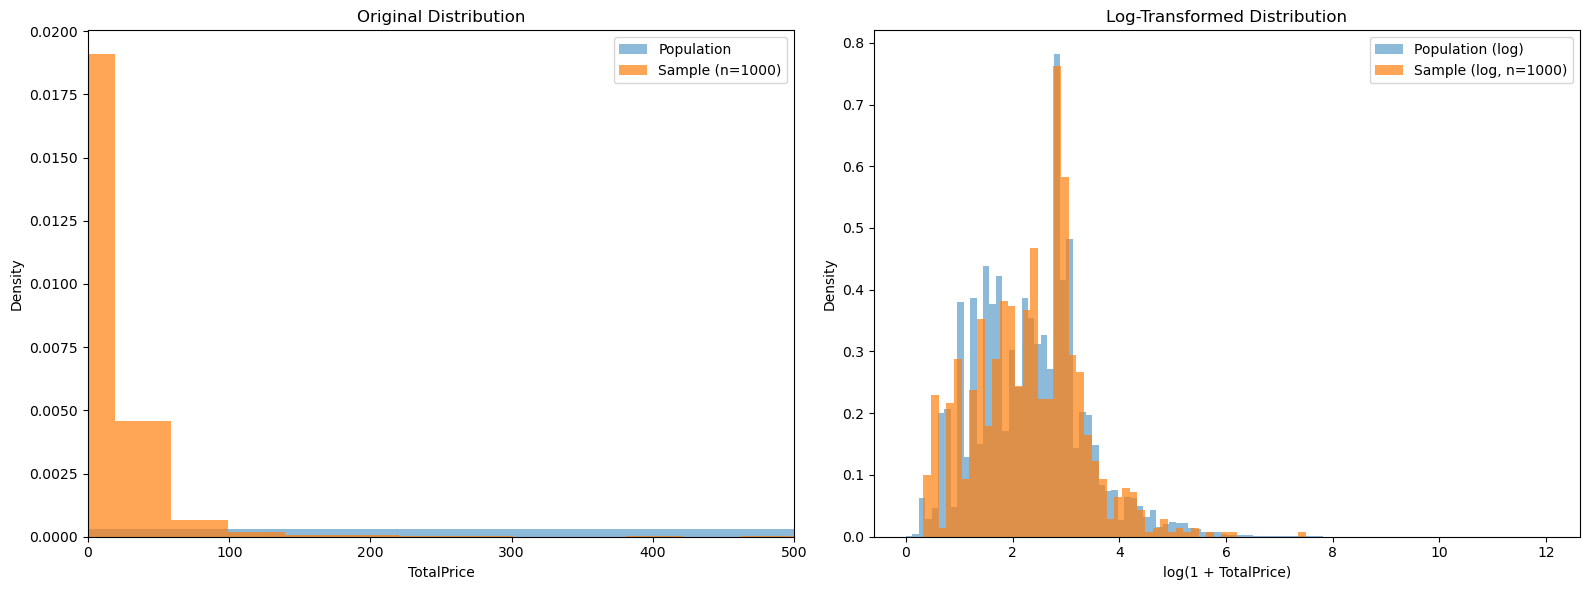

In [7]:
population = df['TotalPrice'].dropna()
sample = population.sample(n=1000, random_state=42)

population_log = np.log1p(population[population > 0])  
sample_log = np.log1p(sample[sample > 0])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].hist(population, bins=100, alpha=0.5, label='Population', density=True)
axes[0].hist(sample, bins=50, alpha=0.7, label='Sample (n=1000)', density=True)
axes[0].set_xlim(0, 500) 
axes[0].set_xlabel('TotalPrice')
axes[0].set_ylabel('Density')
axes[0].set_title('Original Distribution')
axes[0].legend()

axes[1].hist(population_log, bins=100, alpha=0.5, label='Population (log)', density=True)
axes[1].hist(sample_log, bins=50, alpha=0.7, label='Sample (log, n=1000)', density=True)
axes[1].set_xlabel('log(1 + TotalPrice)')
axes[1].set_ylabel('Density')
axes[1].set_title('Log-Transformed Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

- 모집단과 표본의 TotalPrice 분포
  - 원래 분포
    - 모집단 : 전체 데이터는 극단적인 값 때문에 오른쪽 꼬리가 길게 나타남
    - 표본 : 1000개 표본에서는 극단값이 덜 잡혀서 분포가 더 좁고 표준편차도 작게 나타남
    - 두 분포의 중심은 비슷하지만, 퍼져 있는 정도는 모집단이 훨씬 넓게 나타남
  - 로그 변환 분포 
    - 로그 변환으로 극단값의 영향을 줄인 후 분포 형태 시각화
    - 모집단과 표본 모두 오른쪽 꼬리가 나타남
    - 평균을 기준으로 표본이 모집단을 잘 근사하고 있음

---

### 2. 주문이 가장 많은 상위 두 국가의 'TotalPrice' 평균에 차이가 있는지 검증하세요.

* 'Country' 변수를 바탕으로 주문이 가장 많은 상위 두 국가를 찾으세요.
* 독립표본 t-검정을 사용하여 두 국가 간 'TotalPrice' 평균의 차이가 통계적으로 유의미한지 검증하세요.  
* t-통계량과 p-값을 해석하여 결과를 설명하고, 1종 오류와 2종 오류의 개념을 적용하여 설명해주세요.

In [8]:
country_counts = df['Country'].value_counts()
countries_top2 = country_counts.head(2).index.tolist()

print('주문건수 상위 2개국 :', countries_top2)

주문건수 상위 2개국 : ['United Kingdom', 'Germany']


In [9]:
country1_data = df[df['Country'] == countries_top2[0]]['TotalPrice']
country2_data = df[df['Country'] == countries_top2[1]]['TotalPrice']

t_stat, p_val = ttest_ind(country1_data, country2_data, equal_var=False)

print(f't-통계량 : {t_stat:.4f}')
print(f'p-값 : {p_val:.4e}')

t-통계량 : -10.0464
p-값 : 9.8234e-24


- 가설 설정
  - 귀무가설(H₀) : 두 국가의 평균 TotalPrice는 차이가 없다.
  - 대립가설(H₁) : 두 국가의 평균 TotalPrice는 차이가 있다.

- t-통계량 ( -10.0464 )
  - 절댓값이 아주 크기때문에 평균 차이가 우연에 의해 발생했을 가능성이 낮다.
  
- p-값 ( 9.8234e-24 )
  - 귀무가설(H₀: 두 국가의 평균이 같다)을 기각하고 대립가설(H₁: 두 국가의 평균이 다르다) 채택
  - 결론 : 두 국가의 TotalPrice 평균은 통계적으로 유의한 차이가 있다.

- 1종 오류 (Type I Error)
  - 실제로는 두 국가 평균에 차이가 없는데 차이가 있다고 잘못 결론 내릴 가능성
  - 현재 p-값이 작아서 1종 오류 가능성은 낮다.

- 2종 오류 (Type II Error)
  - 실제로는 두 국가 평균에 차이가 있는데 차이가 없다고 잘못 결론 내리는 경우
  - 귀무가설을 기각했으므로 해당 상황은 발생하지 않는다.

---

### 3. 주중, 주말에 따라서 발생하는 UnitPrice의 분포가 달라지는지 확인하세요.

* 주중의 'UnitPrice'와 주말의 'UnitPrice'의 분포를 분석하기 위해 데이터의 중심경향치(평균, 중간값), 변산성(표준편차, 분산), 분위수를 계산하세요.  
* 상자수염그림과 히스토그램을 그려 시각화를 통해 분포를 확인하고 데이터의 분포에 대해 설명해주세요.

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['WeekType'] = df['DayOfWeek'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

stats_summary = df.groupby('WeekType')['UnitPrice'].agg(mean='mean',median='median',std='std',var='var',
                                                        q25=lambda x:x.quantile(0.25),q75=lambda x:x.quantile(0.75))
print(stats_summary)

C:\Users\Administrator\AppData\Local\Temp;\ipykernel_10888\1703918085.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


              mean  median         std           var   q25   q75
WeekType                                                        
Weekday   4.843425    2.10  103.032058  10615.604927  1.25  4.13
Weekend   2.887824    1.85    7.959497     63.353599  1.25  3.75


- 중심경향치 (평균 vs 중앙값)
  - 주중 평균(4.84)이 주중 중앙값(2.10)보다 훨씬 큼   
    → 초고가 상품(아웃라이어)이 평균을 끌어올린다.
  - 주말도 평균(2.89)이 중앙값(1.85)보다 크긴하지만 상대적으로 작음   
    → 주말에는 고가 아웃라이어가 덜 등장한다.

- 변산성 (표준편차/분산)
  - 주중 표준편차(103.03)와 분산(10615.60)이 매우 큼  
    → 일부 거래에서 초고가의 상품이 포함되어 분포가 크게 퍼져 있다.
  - 주말 표준편차(7.96)는 상대적으로 안정적    
    → 주말에는 대부분 저가~중저가 상품 위주로 거래된다.

- 분위수
  - 1사분위수 : 1.25 
  - 3사분위수 : 4.13(주중), 3.75(주말)   
  → 거래의 50%가량은 주중·주말 구분 없이 모두 1.25~4.0 파운드 사이의 상품을 거래하지만,   
    주중에는 이 범위를 벗어나 초고가 제품이 섞여 있어 평균과 분산을 키운 것으로 보인다.

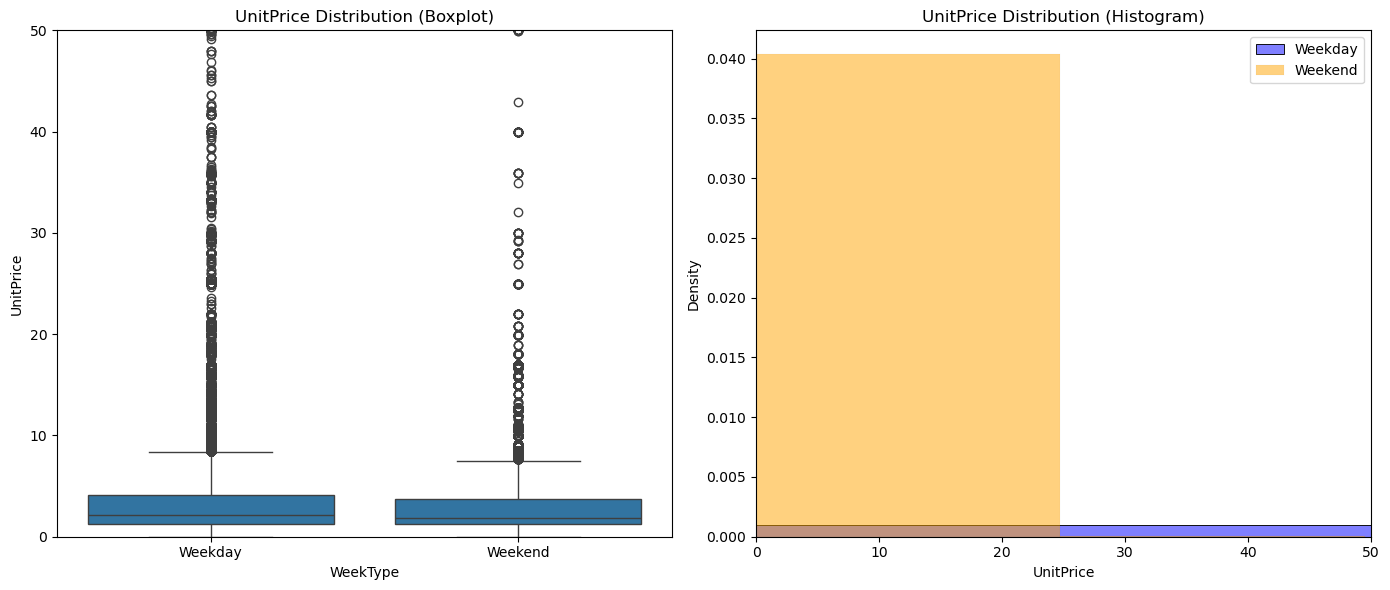

In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='WeekType', y='UnitPrice', data=df)
plt.ylim(0, 50)  
plt.title('UnitPrice Distribution (Boxplot)')

plt.subplot(1, 2, 2)
sns.histplot(df[df['WeekType']=='Weekday']['UnitPrice'],bins=50,color='blue',alpha=0.5,label='Weekday',stat='density')
sns.histplot(df[df['WeekType']=='Weekend']['UnitPrice'],bins=50,color='orange',alpha=0.5,label='Weekend',stat='density')
plt.xlim(0, 50)
plt.title('UnitPrice Distribution (Histogram)')
plt.legend()

plt.tight_layout()
plt.show()

- Boxplot 
  - 주중과 주말 모두 대부분의 값이 낮은 구간(0~5 파운드)에 밀집되어 있다.
  - 아웃라이어가 많이 확인되는데 주중에 그 강도가 심하다. 

- Histogram
  - 주중과 주말 모두 대부분의 값이 낮은 구간(0~5 파운드)에 밀집되어 있다.
  - 주중은 긴 꼬리를 가지며 낮은 밀도이긴 하지만 25 파운드 이상 구간까지 확산됨
  - 주말은 밀도가 거의 25 파운드 구간에서만 형성되어 있고 멀리 퍼지지 않음 → 안정적인 가격대

  → 주중에는 다양한 가격대의 상품 거래가 포함되어 평균과 분산이 크고, 주말에는 저가 중심의 거래가 주를 이루어 분포가 안정적이다.

---

### 4. 상품의 단가와 판매 국가, 판매 날짜을 이용해 판매 수량을 예측하는 회귀 모델을 만드세요.
* 필요한 데이터를 정리하고 결측치와 이상치를 제거해주세요.  
* 변수를 다음과 같이 설정하여 다중 선형 회귀 분석을 진행하세요.
    * 종속변수: 판매 수량(`Quantity`)
    * 독립변수: 상품 단가(`UnitPrice`), 판매 국가(`Country`), 판매 요일(`DayOfWeek`), 판매 월( `InvoiceMonth`)   
* 회귀계수와 결정계수를 활용하여 회귀 분석 결과를 해석해주세요.

In [ ]:
df1 = df.copy()

df1 = df1.dropna(subset=['Quantity', 'UnitPrice', 'Country', 'InvoiceDate'])
df1 = df1[(df1['Quantity'] > 0) & (df1['UnitPrice'] > 0)]

df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'].astype(str), errors='coerce')
df1['InvoiceMonth'] = df1['InvoiceDate'].dt.month
df1['DayOfWeek'] = df1['InvoiceDate'].dt.dayofweek

In [13]:
model = smf.ols('Quantity ~ UnitPrice + C(Country) + C(DayOfWeek) + C(InvoiceMonth)', data=df1).fit(cov_type='HC3') 

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     90.23
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:46:57   Log-Likelihood:            -3.4270e+06
No. Observations:              530104   AIC:                         6.854e+06
Df Residuals:                  530049   BIC:                         6.855e+06
Df Model:                          54                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

- R-squared / Adj. R-squared : 0.002
  - 설명력이 떨어짐
  - 이 변수들만으로는 변동의 일부만 설명
- F-statistic : 90.23
  - 설명변수들이 전혀 도움이 안 된다라는 귀무가설은 기각
  - 적어도 일부 변수는 수량과 유의한 관련이 있다
- No. Observations : 530104
  - 크기가 큰 표본에서는 아주 작은 효과도 유의하게 보일 수 있기때문에 효과의 크기를 함께 봐야 함
- Intercept(절편) : 69.9235
  - UnitPrice=0일 때의 예측 수량..? 기준점 정도로만 파악
- C(Country)[T.X]
  - 기준국가보다 건당 수량이 적다는 정도만 알 수 있음
- C(DayOfWeek)[T.X]
  - 월요일과 비교했을 때, 대체로 화·수·목에 더 많이 팔리고 일요일은 적게 팔림
- C(InvoiceMonth)[T.X]
  - 뚜렷한 계절성은 보이지 않음
- UnitPrice                             
  - coef = -0.0165, p = 0.018 → 유의

→ 가격이 오를수록 판매량이 떨어진다. (유의하지만 효과는 작음)   
→ 수,목요일에 판매량이 늘어나고 일요일은 떨어진다.

In [14]:
coef_table = pd.DataFrame({'coef': model.params,
                           'std_err': model.bse,
                           't': model.tvalues,
                           'p>|t|': model.pvalues}).sort_values('p>|t|')

r2 = model.rsquared
adj_r2 = model.rsquared_adj

print(f'R²:{r2:.4f} | Adjusted R²:{adj_r2:.4f}')
print('\nCoefficient Table (by p-value)')
display(coef_table.head())  

R²:0.0018 | Adjusted R²:0.0017

Coefficient Table (by p-value)


,coef,std_err,t,p>|t|
C(Country)[T.RSA],-65.439894,2.937673,-22.276096,6.301662e-110
C(Country)[T.Unspecified],-63.653863,2.926636,-21.749840,6.932125e-105
C(Country)[T.United Kingdom],-60.639955,2.884722,-21.021071,4.208283e-98
Intercept,69.923534,3.368233,20.759709,1.001705e-95
C(Country)[T.Portugal],-59.821293,2.893673,-20.673134,6.045970e-95


- 표본이 매우 커서 통계적으로는 유의하지만 모델의 R²가 매우 낮음 → 현재 변수들만으로 전체 수량 변동을 거의 설명하지 못합니다.
- 국가 더미가 많아 다중공선성 문제가 발생한것으로 추정 

In [15]:
X_vif = dmatrix('UnitPrice + C(Country) + C(DayOfWeek) + C(InvoiceMonth)', data=df1, return_type='dataframe')

if 'Intercept' in X_vif.columns:
    X_vif = X_vif.drop(columns=['Intercept'])

vif_df = pd.DataFrame({'feature': X_vif.columns,
                       'VIF': [variance_inflation_factor(X_vif.to_numpy(), i)for i in range(X_vif.shape[1])]
                       }).sort_values('VIF', ascending=False)

print(vif_df.head())

                         feature        VIF
35  C(Country)[T.United Kingdom]  17.527036
51         C(InvoiceMonth)[T.11]   3.391176
52         C(InvoiceMonth)[T.12]   2.904814
50         C(InvoiceMonth)[T.10]   2.690597
49          C(InvoiceMonth)[T.9]   2.412263


- 국가 중 영국이 차지하는 비중이 압도적으로 커서 다른 국가 더미들의 선형결합에 강하게 영향을 줌 → 다중공선성이 문제
- 해결 방법
  - 국가 차원 축소 : 영국 또는 상위n개 국가 / 나머지 국가
  - 규제 추가 : Ridge
  - 영국을 레퍼런스로 두고 재진단 ...?

---

### 5. 상품 정보와 거래 정보를 바탕으로 해당 거래가 반품될 가능성을 예측하는 로지스틱 회귀 모델을 만드세요.
* 필요한 데이터를 정리하고 결측치와 이상치를 제거해주세요.  
* `Quantity` 피쳐를 활용해 `IsReturn` 피쳐를 생성하세요.
* 모델 학습에 사용할 적절한 피쳐를 선정하세요.
* 모델 학습과 검증을 위해 데이터셋을 train셋과 test셋으로 나누세요.
* `IsReturn`을 예측하는 로지스틱 회귀 모델을 학습하세요.
* 혼동행렬, 정밀도, 재현율, F1-score 등 다양한 평가지표를 사용하여 모델의 성능을 평가하세요.
* 모델의 성능을 더 높일 수 있는 방안에 대해서 고민해보세요.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier

In [ ]:
df_clf = df.copy()

df_clf['InvoiceDate'] = pd.to_datetime(df_clf['InvoiceDate'], errors='coerce')
df_clf = df_clf.dropna(subset=['InvoiceDate', 'Country', 'UnitPrice', 'Quantity']).copy()

df_clf['IsReturn'] = (df_clf['Quantity'] < 0).astype(int)
df_clf['DayOfWeek'] = df_clf['InvoiceDate'].dt.dayofweek   
df_clf['InvoiceMonth'] = df_clf['InvoiceDate'].dt.month       

feature_cols = ['UnitPrice', 'DayOfWeek', 'InvoiceMonth', 'Country']
X = df_clf[feature_cols].copy()
y = df_clf['IsReturn'].copy()

print('Return rate (overall) :', y.mean())

Return rate (overall) : 0.019604767590130447


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_features = ['UnitPrice']
cat_features = ['Country', 'DayOfWeek', 'InvoiceMonth'] 

preprocess = ColumnTransformer(transformers=[('num', StandardScaler(), num_features),
                                             ('cat', OneHotEncoder(handle_unknown='ignore'), 
                                              cat_features)],remainder='drop')

clf = Pipeline(steps=[('prep', preprocess),
                      ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', 
                                                    solver='lbfgs', random_state=42))])

clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['UnitPrice']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Country', 'DayOfWeek',
                                                   'InvoiceMonth'])])),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Confusion matrix
 [[60551 45706]
 [  867  1258]]

Classification report
              precision    recall  f1-score   support

           0     0.9859    0.5699    0.7222    106257
           1     0.0268    0.5920    0.0513      2125

    accuracy                         0.5703    108382
   macro avg     0.5063    0.5809    0.3867    108382
weighted avg     0.9671    0.5703    0.7091    108382



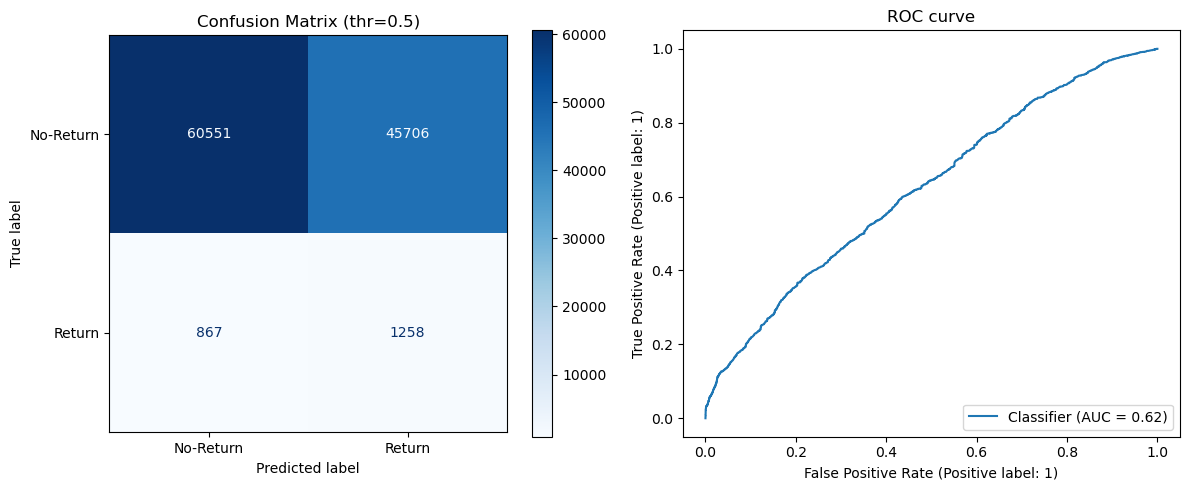

In [19]:
y_pred  = clf.predict(X_test)
y_prob  = clf.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n', cm)

print('\nClassification report')
print(classification_report(y_test, y_pred, digits=4))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm, display_labels=['No-Return','Return']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix (thr=0.5)')

RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1])
ax[1].set_title('ROC curve')
plt.tight_layout()
plt.show()

---

In [20]:
df_fe = df.copy()

# 날짜 변환 → 결측 드롭 (순서 중요)
df_fe['InvoiceDate'] = pd.to_datetime(df_fe['InvoiceDate'], errors='coerce')
req_cols = ['InvoiceDate','Country','UnitPrice','Quantity','InvoiceNo','StockCode']
df_fe = df_fe.dropna(subset=req_cols).copy()

# 라벨 : 반품 여부 (Quantity < 0)
df_fe['IsReturn'] = (df_fe['Quantity'] < 0).astype(int)

# 시간 파생변수
df_fe['DayOfWeek'] = df_fe['InvoiceDate'].dt.dayofweek  
df_fe['InvoiceMonth'] = df_fe['InvoiceDate'].dt.month      
df_fe['Hour'] = df_fe['InvoiceDate'].dt.hour

# 장바구니 맥락(InvoiceNo 단위) — 누설 방지: Quantity 미사용
basket = (df_fe.groupby('InvoiceNo', as_index=False).agg(basket_lines=('StockCode','nunique'),
                                                         basket_avg_price=('UnitPrice','mean')))
df_fe = df_fe.merge(basket, on='InvoiceNo', how='left')


# 과거 반품 이력(고객/상품/국가) 
df_fe = df_fe.sort_values('InvoiceDate').reset_index(drop=True)

def past_stats(df_, key, label='IsReturn'):
    """
    key별로 '현재 행 이전'까지의
      - prev_orders (이전 거래 수)
      - prev_returns (이전 반품 수)
      - prev_return_rate (이전 반품률)
    을 벡터화로 생성해 반환
    """
    key_series = df_[key]
    ones = pd.Series(1.0, index=df_.index)
    prev_orders  = ones.groupby(key_series).cumsum().shift(1).fillna(0.0)
    prev_returns = df_[label].groupby(key_series).cumsum().shift(1).fillna(0.0)
    prev_rate    = (prev_returns / prev_orders.replace(0.0, np.nan)).fillna(0.0)
    return prev_orders.astype(float), prev_returns.astype(float), prev_rate.astype(float)

df_fe['cust_prev_orders'], df_fe['cust_prev_returns'], df_fe['cust_prev_return_rate'] = past_stats(df_fe, 'CustomerID')
df_fe['prod_prev_orders'], df_fe['prod_prev_returns'], df_fe['prod_prev_return_rate'] = past_stats(df_fe, 'StockCode')
df_fe['ctry_prev_orders'], df_fe['ctry_prev_returns'], df_fe['ctry_prev_return_rate'] = past_stats(df_fe, 'Country')

# 마지막 거래 이후 경과일(고객/상품)
df_fe['cust_prev_date'] = df_fe.groupby('CustomerID')['InvoiceDate'].shift(1)
df_fe['prod_prev_date'] = df_fe.groupby('StockCode')['InvoiceDate'].shift(1)

df_fe['days_since_cust'] = (df_fe['InvoiceDate'] - df_fe['cust_prev_date']).dt.total_seconds() / 86400
df_fe['days_since_prod'] = (df_fe['InvoiceDate'] - df_fe['prod_prev_date']).dt.total_seconds() / 86400
df_fe['days_since_cust'] = df_fe['days_since_cust'].fillna(9999.0)
df_fe['days_since_prod'] = df_fe['days_since_prod'].fillna(9999.0)

# 과거 상품 평균가 대비 현재가 편차 : expanding().mean().shift(1)로 현재 제외한 과거 평균가를 사용 → 누설 방지
tmp = (df_fe.groupby('StockCode')['UnitPrice'].apply(lambda s: s.expanding().mean().shift(1)))
df_fe['prod_prev_mean_price'] = tmp.reset_index(level=0, drop=True)
df_fe['prod_prev_mean_price'] = df_fe['prod_prev_mean_price'].fillna(df_fe['UnitPrice'].median())
df_fe['price_dev_from_prod_mean'] = df_fe['UnitPrice'] - df_fe['prod_prev_mean_price']

# 최종 피처 구성 
num_cols = ['UnitPrice','Hour','basket_lines','basket_avg_price','cust_prev_orders',
            'cust_prev_return_rate','prod_prev_orders','prod_prev_return_rate',
            'ctry_prev_return_rate','days_since_cust','days_since_prod','price_dev_from_prod_mean']
cat_cols = ['Country','DayOfWeek','InvoiceMonth']

X = df_fe[num_cols + cat_cols].copy()
y = df_fe['IsReturn'].astype(int)

# 시간 기반 분리 (과거 80% 학습 / 최근 20% 평가)
cutoff = df_fe['InvoiceDate'].quantile(0.8)
X_train, X_test = X[df_fe['InvoiceDate'] <= cutoff], X[df_fe['InvoiceDate'] > cutoff]
y_train, y_test = y[df_fe['InvoiceDate'] <= cutoff], y[df_fe['InvoiceDate'] > cutoff]

print('Train size :', len(y_train), ', Test size :', len(y_test))
print('Return rate train/test :', y_train.mean().round(4), y_test.mean().round(4))


Train size : 433527 , Test size : 108382
Return rate train/test : 0.0209 0.0144


In [21]:
pre = ColumnTransformer([('num', StandardScaler(), num_cols),
                         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)],remainder='drop')

In [ ]:
# 로지스틱 회귀
logit = Pipeline([('prep', pre),
                  ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', 
                                             solver='lbfgs', random_state=42))])
logit.fit(X_train, y_train)
p_log = logit.predict_proba(X_test)[:,1]
pred_log = (p_log>=0.5).astype(int)

print('[Logistic] ROC-AUC :', roc_auc_score(y_test, p_log).round(4),
      ' , PR-AUC :', average_precision_score(y_test, p_log).round(4))
print('\n', confusion_matrix(y_test, pred_log))
print('\n',classification_report(y_test, pred_log, digits=4))

[Logistic] ROC-AUC : 0.9756  , PR-AUC : 0.2794

 [[97190  9636]
 [   52  1504]]

               precision    recall  f1-score   support

           0     0.9995    0.9098    0.9525    106826
           1     0.1350    0.9666    0.2369      1556

    accuracy                         0.9106    108382
   macro avg     0.5672    0.9382    0.5947    108382
weighted avg     0.9871    0.9106    0.9423    108382



In [23]:
# 랜덤 포레스트 
rf = Pipeline([('prep', pre),
               ('clf', RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=10, 
                                              min_samples_leaf=5, class_weight='balanced', n_jobs=-1, random_state=42))])
rf.fit(X_train, y_train)
p_rf = rf.predict_proba(X_test)[:,1]
pred_rf = (p_rf>=0.5).astype(int)

print('[RandomForest] ROC-AUC :', roc_auc_score(y_test, p_rf).round(4),
      ' , PR-AUC:', average_precision_score(y_test, p_rf).round(4))
print('\n',confusion_matrix(y_test, pred_rf))
print('\n',classification_report(y_test, pred_rf, digits=4))

[RandomForest] ROC-AUC : 0.9866  , PR-AUC: 0.5301

 [[105518   1308]
 [   474   1082]]

               precision    recall  f1-score   support

           0     0.9955    0.9878    0.9916    106826
           1     0.4527    0.6954    0.5484      1556

    accuracy                         0.9836    108382
   macro avg     0.7241    0.8416    0.7700    108382
weighted avg     0.9877    0.9836    0.9853    108382



In [24]:
# 임계값 튜닝(F1 최대) 
def best_f1_threshold(y_true, prob):
    prec, rec, thr = precision_recall_curve(y_true, prob)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    i = f1[:-1].argmax()
    return float(thr[i]), float(f1[i]), float(prec[i]), float(rec[i])

for name, prob in [('Logistic', p_log), ('RandomForest', p_rf)]:
    thr, f1b, pb, rb = best_f1_threshold(y_test, prob)
    pred_b = (prob>=thr).astype(int)
    print(f'\n[{name}] Best F1 threshold={thr:.3f} | F1={f1b:.4f} | P={pb:.4f} | R={rb:.4f}')
    print('\n', confusion_matrix(y_test, pred_b))


[Logistic] Best F1 threshold=0.829 | F1=0.3876 | P=0.2614 | R=0.7500

 [[103528   3298]
 [   389   1167]]

[RandomForest] Best F1 threshold=0.620 | F1=0.5814 | P=0.5502 | R=0.6163

 [[106042    784]
 [   597    959]]


In [25]:
xgb = Pipeline([('prep', pre),
                ('clf', XGBClassifier(n_estimators=600, max_depth=6, learning_rate=0.05, subsample=0.8, 
                                      colsample_bytree=0.8, reg_lambda=1.0, random_state=42,
                                      scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])))])

xgb.fit(X_train, y_train)
p_xgb = xgb.predict_proba(X_test)[:,1]
print('[XGBoost] ROC-AUC :', roc_auc_score(y_test, p_xgb).round(4),
      ' , PR-AUC :', average_precision_score(y_test, p_xgb).round(4))

[XGBoost] ROC-AUC : 0.9869  , PR-AUC : 0.5811


Confusion matrix
 [[104707   2119]
 [   336   1220]]

Classification report
              precision    recall  f1-score   support

           0     0.9968    0.9802    0.9884    106826
           1     0.3654    0.7841    0.4985      1556

    accuracy                         0.9773    108382
   macro avg     0.6811    0.8821    0.7434    108382
weighted avg     0.9877    0.9773    0.9814    108382



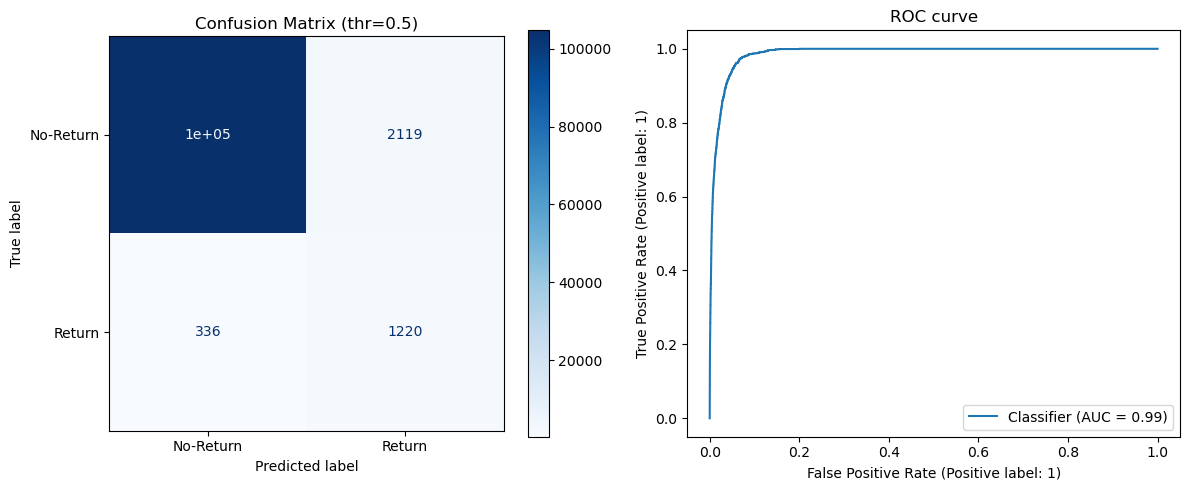

In [26]:
y_pred  = xgb.predict(X_test)
y_prob  = xgb.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n', cm)

print('\nClassification report')
print(classification_report(y_test, y_pred, digits=4))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm, display_labels=['No-Return','Return']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix (thr=0.5)')

RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1])
ax[1].set_title('ROC curve')
plt.tight_layout()
plt.show()